# Описание проекта

**Задача:** подготовить прототип модели машинного обучения для компании, которая разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

**Описание данных** 

**Технологический процесс**
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**

* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]
Пример: rougher.input.feed_ag
Возможные значения для блока [этап]:

* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

**Возможные значения для блока [тип_параметра]:**

* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики


# 1. Подготовка данных

In [1]:
import pandas as pd
import random
import warnings
import numpy as np
import seaborn as sns
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


* **1.1. Открываем файлы и изучаем их**

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
data = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
def data_info(data):
    data.info()

In [4]:
data_info(train)
data_info(test)
data_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

В датасетах есть пропуски. Напишем функцию, чтобы увидеть какой процент пропусков мы имеем в том или ином столбце:

In [5]:
def calc_null(data):
    print('Столбец','Пропуски, %')
    for col in data.columns:
        null_col = data[col].isnull().sum() / len(data)
        print('{:<50}{:.1%}'.format(col, null_col))

Пропуски в датасете *Train*:

In [6]:
calc_null(train)

Столбец Пропуски, %
date                                              0.0%
final.output.concentrate_ag                       0.4%
final.output.concentrate_pb                       0.4%
final.output.concentrate_sol                      2.2%
final.output.concentrate_au                       0.4%
final.output.recovery                             9.0%
final.output.tail_ag                              0.4%
final.output.tail_pb                              1.1%
final.output.tail_sol                             0.9%
final.output.tail_au                              0.4%
primary_cleaner.input.sulfate                     7.8%
primary_cleaner.input.depressant                  7.5%
primary_cleaner.input.feed_size                   0.0%
primary_cleaner.input.xanthate                    5.8%
primary_cleaner.output.concentrate_ag             0.5%
primary_cleaner.output.concentrate_pb             2.1%
primary_cleaner.output.concentrate_sol            3.8%
primary_cleaner.output.concentrate_au        

Пропуски в датасете *Test*:

In [7]:
calc_null(test)

Столбец Пропуски, %
date                                              0.0%
primary_cleaner.input.sulfate                     5.2%
primary_cleaner.input.depressant                  4.8%
primary_cleaner.input.feed_size                   0.0%
primary_cleaner.input.xanthate                    2.8%
primary_cleaner.state.floatbank8_a_air            0.3%
primary_cleaner.state.floatbank8_a_level          0.3%
primary_cleaner.state.floatbank8_b_air            0.3%
primary_cleaner.state.floatbank8_b_level          0.3%
primary_cleaner.state.floatbank8_c_air            0.3%
primary_cleaner.state.floatbank8_c_level          0.3%
primary_cleaner.state.floatbank8_d_air            0.3%
primary_cleaner.state.floatbank8_d_level          0.3%
rougher.input.feed_ag                             0.3%
rougher.input.feed_pb                             0.3%
rougher.input.feed_rate                           0.7%
rougher.input.feed_size                           0.4%
rougher.input.feed_sol                       

Пропуски в датасете *Data*:

In [8]:
calc_null(data)

Столбец Пропуски, %
date                                              0.0%
final.output.concentrate_ag                       0.4%
final.output.concentrate_pb                       0.4%
final.output.concentrate_sol                      1.7%
final.output.concentrate_au                       0.4%
final.output.recovery                             8.6%
final.output.tail_ag                              0.4%
final.output.tail_pb                              0.9%
final.output.tail_sol                             1.2%
final.output.tail_au                              0.4%
primary_cleaner.input.sulfate                     7.1%
primary_cleaner.input.depressant                  6.8%
primary_cleaner.input.feed_size                   0.0%
primary_cleaner.input.xanthate                    5.1%
primary_cleaner.output.concentrate_ag             0.4%
primary_cleaner.output.concentrate_pb             2.0%
primary_cleaner.output.concentrate_sol            3.5%
primary_cleaner.output.concentrate_au        

Итак, пропуски присутствуют. Поговорим поподробнее о каждом датасете:

* В **Train** пропуски достигают 15,3% от всего объёма данных;
* В **Test** пропуски достигают 5,2% от всего объёма данных;
* В **Data** пропуски достигают 13,7% от всего объёма данных.

Проверим на наличие дубликатов:

In [9]:
def data_dupl(data):
    print(data.duplicated().sum())

In [10]:
data_dupl(train)
data_dupl(test)
data_dupl(data)

0
0
0


Дубликатов нет.

* **1.2. Проверим, что эффективность обогащения рассчитана правильно.**

* Вычислим эффективность обогащения на обучающей выборке для признака rougher.output.recovery:

In [11]:
aurum_after_cleaning = train['rougher.output.concentrate_au']
aurum_before_cleaning = train['rougher.input.feed_au']
aurum_in_tails = train['rougher.output.tail_au']

train['recovery_mine'] = ((aurum_after_cleaning * (aurum_before_cleaning - aurum_in_tails)) / (aurum_before_cleaning * (aurum_after_cleaning - aurum_in_tails)))*100

Сделаем срез и сравним посчитанную эффективность и ту, что дана по заданию:

In [12]:
train.loc[:, ['rougher.output.recovery', 'recovery_mine']]

,rougher.output.recovery,recovery_mine
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
16855,89.574376,89.574376
16856,87.724007,87.724007
16857,88.890579,88.890579
16858,89.858126,89.858126


На первый взгляд, ошибок в подсчётах нет. Посчитаем среднюю ошибку:

In [13]:
train.dropna(subset = ['rougher.output.recovery','recovery_mine'],inplace = True)
MAE = mean_absolute_error(train['rougher.output.recovery'], train['recovery_mine'])
MAE

9.444891926100695e-15

Вывод: признак *rougher.output.recovery* в обучающем датасете посчитан **верно**.

Удалим наш столбец "recovery_mine":

In [14]:
del train['recovery_mine']

* **1.3. Проанализируем признаки, недоступные в тестовой выборке.**

In [15]:
data_col = data.columns
test_col = test.columns
rest = set(data_col) - set(test_col)

Получаем список признаком, которые отсутствуют в тестовой выборке:

In [16]:
rest

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Все отсутствующие признаки относятся к типу "число с плавающей запятой" **float64**

* **1.4. Произведём предобработку данных.**

заполним пропуски в датасетах методом линейной интерполяции:

In [17]:
data.interpolate(inplace=True)
train.interpolate(inplace=True)
test.interpolate(inplace=True)

Проверим, остались ли пропуски:

In [18]:
data.isnull().sum().sum()
train.isnull().sum().sum()
test.isnull().sum().sum()

0

**ВЫВОД:** 
* Файлы открыты и изучены;
* Убедились в том, что эффективность обогащения рассчитана правильно;
* Обнаружили признаки, недоступные в тестовой выборке. Эти параметры относятся к типу float64;
* Заполнили пропуски методом линейной интерполяции.

# 2. Анализ данных

* **2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.**

Итак, у нас 4 основных этапа, где будем отслеживать концентрацию металлов.
В скобках укажем, какие нам нужны столбцы.
Будем исследовать концентрацию...:
* ...в изначальной  смеси ('rougher.input.feed_')
* ...после флотации ('rougher.output.concentrate_')
* ...после первого этапа очистки ('primary_cleaner.output.concentrate_')
* ...в финальном концентрате ('final.output.concentrate_')

Сделаем срезы для удобства построения гистограмм (датасет *data_Sol* понадобится нам в следующем пункте проекта):

In [19]:
cols_Au = ['rougher.input.feed_au', 'rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']
cols_Ag = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']
cols_Pb = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']
cols_Sol = ['rougher.input.feed_sol', 'rougher.output.concentrate_sol','primary_cleaner.output.concentrate_sol','final.output.concentrate_sol']

In [20]:
data_Au = data.loc[:, cols_Au]
data_Ag = data.loc[:, cols_Ag]
data_Pb = data.loc[:, cols_Pb]
data_Sol = data.loc[:, cols_Sol]

In [21]:
def print_plot(data,cols):
    plt.figure(figsize=(16,6))
    ax = sns.violinplot(x='variable', y='value', data=pd.melt(data[cols]))

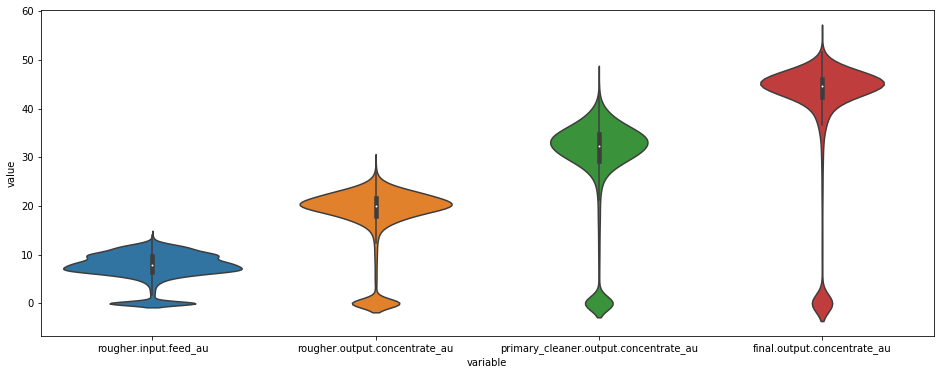

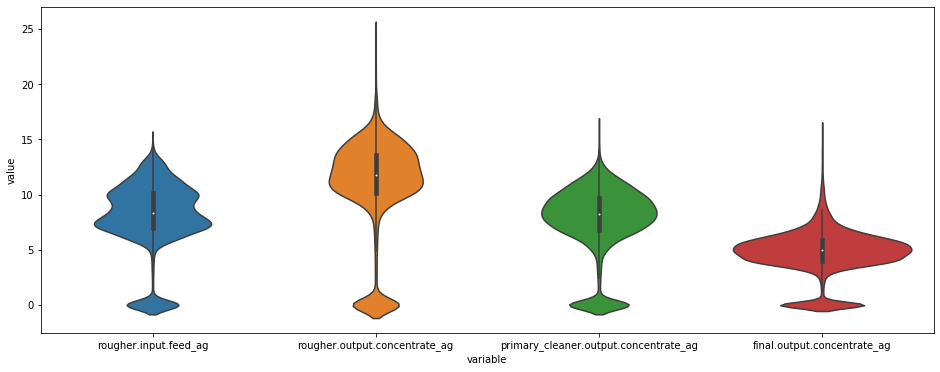

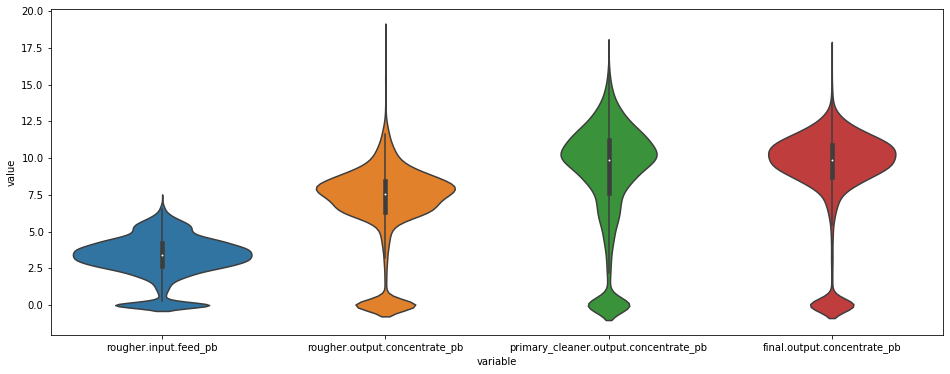

In [22]:
print_plot(data_Au,cols_Au)
print_plot(data_Ag,cols_Ag)
print_plot(data_Pb,cols_Pb)

Отчётливо видим, как линейно возрастает концентрация золота в нашей смеси.
Серебро падает нелинейно.
Свинец возрастает нелинейно.
В районе нуля отчёливо видим выбросы.

* **2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.**

In [23]:
def plot_hist(data,col,a,b):
    data[col].plot(kind='hist', alpha = 0.5, bins = 100, range=(a, b))
    plt.xlabel('размер гранул сырья')

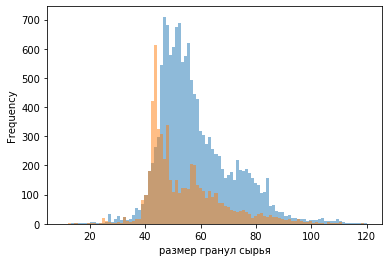

In [24]:
plot_hist(train,'rougher.input.feed_size',10,120)
plot_hist(test,'rougher.input.feed_size',10,120)

Будем считать, что распределения близки друг к другу.

* **2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.**

Создадим датафрейм с суммарной концентрацией:

In [25]:
data_all2 = data_Au.join(data_Ag, how='inner')
data_all1 = data_all2.join(data_Pb, how='inner')
data_all = data_all1.join(data_Sol, how='inner')
data_all['sum_1'] = data_all['rougher.input.feed_au'] + data_all['rougher.input.feed_ag'] + data_all['rougher.input.feed_pb'] + data_all['rougher.input.feed_sol']  
data_all['sum_2'] = data_all['rougher.output.concentrate_au'] + data_all['rougher.output.concentrate_ag'] + data_all['rougher.output.concentrate_pb']  + data_all['rougher.output.concentrate_sol'] 
data_all['sum_3'] = data_all['primary_cleaner.output.concentrate_au'] + data_all['primary_cleaner.output.concentrate_ag'] + data_all['primary_cleaner.output.concentrate_pb']  + data_all['primary_cleaner.output.concentrate_sol'] 
data_all['sum_4'] = data_all['final.output.concentrate_au'] + data_all['final.output.concentrate_ag'] + data_all['final.output.concentrate_pb'] + data_all['final.output.concentrate_sol']
data_all_conc = data_all.loc[:, 'sum_1': 'sum_4']
data_all_conc

,sum_1,sum_2,sum_3,sum_4
0,51.680034,66.424950,72.640924,63.644396
1,50.659114,67.012710,72.543485,63.957723
2,50.609929,66.103793,72.095042,64.311180
3,51.061546,65.752751,59.957723,63.573449
4,47.859163,65.908382,71.321010,64.004667
...,...,...,...,...
22711,53.415050,70.781325,59.001692,68.098589
22712,53.696482,70.539603,59.703912,68.274362
22713,54.589604,55.376330,59.561096,68.226068
22714,54.027355,69.201689,57.216686,68.200449


Построим распределение суммарной концентраций для четырёх стадий:

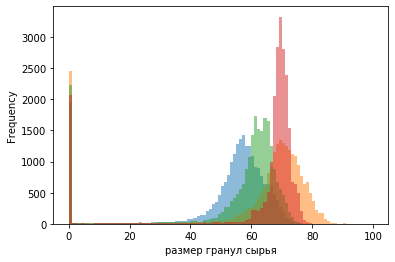

In [26]:
plot_hist(data_all_conc,'sum_1',0,100)
plot_hist(data_all_conc,'sum_2',0,100)
plot_hist(data_all_conc,'sum_3',0,100)
plot_hist(data_all_conc,'sum_4',0,100)

Заметили аномальные значения в районе нуля. Наведём-ка зум:

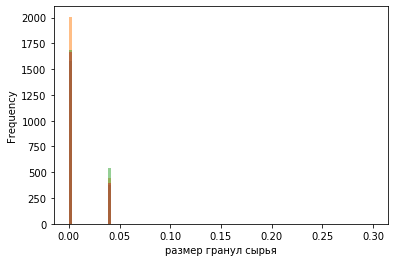

In [27]:
plot_hist(data_all_conc,'sum_1',0,0.3)
plot_hist(data_all_conc,'sum_2',0,0.3)
plot_hist(data_all_conc,'sum_3',0,0.3)
plot_hist(data_all_conc,'sum_4',0,0.3)

Аномальные данные лежат в диапазоне до 0,05. Их необходимо удалить.
Удаляем эти аномальные значения из наших выборок:

In [28]:
colcol = cols_Au + cols_Ag + cols_Pb + cols_Sol

In [29]:
data.loc[:, colcol] = data.loc[:, colcol][data.loc[:, colcol] > 0.05] 

In [30]:
train.loc[:, colcol] = train.loc[:, colcol][train.loc[:, colcol] > 0.05] 

In [31]:
colcol_test = ['rougher.input.feed_ag', 'rougher.input.feed_pb','rougher.input.feed_sol','rougher.input.feed_au']

In [32]:
test.loc[:, colcol_test] = test.loc[:, colcol_test][train.loc[:, colcol_test] > 0.05] 

Проверим отфильтрованные датасеты на наличие пропущенных значений:

In [33]:
data.isnull().sum().sum()

34921

In [34]:
test.isnull().sum().sum()

3343

In [35]:
train.isnull().sum().sum()

2733

Там, где концентрация < 0.05, появились пропущенные значения. Удалим их:

In [36]:
data = data.dropna()
test = test.dropna()
train = train.dropna()

**ВЫВОД:** 
* Линейно возрастает концентрация золота в нашей смеси по мере продвижения к финальной стадии процесса.
* Концентрация серебра падает нелинейно.
* Концентрация свинца возрастает нелинейно.
* Распределения размеров гранул сырья на обучающей и тестовой выборках близки друг к другу.
* Исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в районе нуля. Удалили из тестовой, обучающей,тренировочной выборок значения концентраций, что меньше 0,05.

# 3. Модель

* **3.1. Напишем функцию для вычисления итоговой sMAPE.**

In [37]:
def sMAPE(target, prediction):
    Target = np.array(target)
    Prediction = np.array(prediction)
    smape = (2 * abs(Target - Prediction)) / (abs(Target) + abs(Prediction))
    
    return (smape.sum() / len(Target)) * 100

In [38]:
def final_sMAPE(target, prediction):
    Target = np.array(target)
    Prediction = np.array(prediction)
    final_smape = 0.25 * sMAPE(Target[0], Prediction[0]) + 0.75 * sMAPE(Target[1], Prediction[1])
    
    return final_smape

* **3.2. Обучим разные модели и оценим их качество кросс-валидацией.**

* **Зададим признаки для последующего обучения моделей:**

Признаки, что есть в тестовой выборке:

In [39]:
test_col = set(test.columns)

Признаки, которых нет в общем (и обучающем) датасете:

In [40]:
extra_ft = set(data.columns) - set(test.columns)

Зададим для обучающей выборки целевой признак (эффективность обогащения руды на стадии флотации и на этапе очистки) и основные признаки (исключим недоступные признаки и дату):

In [41]:
features_tr = train.drop(['date', *extra_ft], axis=1)
target_tr = train.loc[:, ['rougher.output.recovery', 'final.output.recovery']]
features_tr.shape, target_tr.shape

((13653, 52), (13653, 2))

Зададим для тестовой выборки признаки:

Небольшая проблема в том, что в тестовой выборке отсутствуют целевые признаки. 

Посмотрим, какая доля строк в тестовой выборке присутствует в общей:

In [42]:
data['date'].isin(test['date']).value_counts()

False    15084
True      4518
Name: date, dtype: int64

Теперь функцией **isin** зададим целевые признаки и объекты:

In [43]:
features_test = data[data['date'].isin(test['date'])][test.columns].drop(columns=['date'])
target_test = data[data['date'].isin(test['date'])].loc[:, ['rougher.output.recovery', 'final.output.recovery']]
features_test.shape, target_test.shape

((4518, 52), (4518, 2))

* **Обучим разные модели и оценим их качество кросс-валидацией.**

In [44]:
smape_score = make_scorer(final_sMAPE, greater_is_better=False)

Обучим случайный лес в регрессии и подберём гиперпараметры:

In [45]:
for est in range(1, 10):
    model_Forest = RandomForestRegressor(random_state=12345, n_estimators=est)
    CV_Forest = cross_val_score(model_Forest, features_tr, target_tr, cv=5, scoring=smape_score)
    print(CV_Forest.mean())

-13.687700321401753
-8.676952364950868
-7.98650530459417
-8.2539072761396
-8.084209937664477
-7.995375018432665
-7.636970712022915
-7.589341866095341
-7.675104458018166


Обучим дерево решений в регрессии и подберём гиперпараметры:

In [46]:
for depth in range(1, 25):
    model_tree = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    CV_tree = cross_val_score(model_tree, features_tr, target_tr, cv=5, scoring=smape_score)
    print(CV_tree.mean())

-9.281768857772333
-7.545451279160915
-7.602916583396026
-7.850508241693518
-7.35107375256824
-8.138656556344342
-7.9434252239809835
-8.19267746953413
-8.383549075197541
-8.018495693565427
-10.833198227485632
-8.290773937584232
-8.619313160047827
-8.320228144306364
-17.70115399755927
-8.206610451555088
-8.831874300983406
-10.30308226996774
-16.569690922110418
-7.44266515274707
-9.92219731372297
-8.746931819949438
-7.770664969023959
-17.542649012938767


Обучим линейной регрессией:

In [47]:
model_LR = LinearRegression()
CV_LR = cross_val_score(model_LR, features_tr, target_tr, cv=5, scoring=smape_score)
CV_LR.mean()

-9.45124691604993

Наименьшую ошибку мы получаем методом дерева решений в регрессии. 

* **3.2. Выбираем лучшую модель и проверяем её на тестовой выборке.**

Лучшей моделью оказывается линейная регрессия. Проверим её на тестовой выборке и найдём окончательную метрику sMAPE:

In [48]:
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=5)
model_tree.fit(features_tr, target_tr)
predictions_tree = model_tree.predict(features_test)

In [49]:
final_sMAPE(target_test, predictions_tree)

2.573387134576362

**ОСНОВНОЙ ВЫВОД:** 
* По результатам кросс-валидации лучшей моделью оказалось дерево решений в регрессии. Подобрали гиперпараметры. Лучший результат при глубине дерева **5**;
* Получили на тестовой выборке итоговый **sMAPE = 2.57%**